# Build Your Own Model

One important feature of `orbit` is to allow users to build and customize some prototype models promptly to serve their own purpose. Users just need to code up the core model structure part, then orbit will facilitate and streamline the downstream functionalities, such as fit-predict, diagnostics, etc.

In this section, we give a demo on how to build up a simple linear model using `Pyro` with orbit through `multi-inheritance` from abstract templates.

In [1]:
import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from copy import deepcopy

import orbit
from orbit.models.template import ModelTemplate
from orbit.forecaster import SVIForecaster
from orbit.estimators.pyro_estimator import PyroEstimatorVI

from orbit.utils.simulation import make_regression
from orbit.diagnostics.plot import plot_predicted_data
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)

1.0.14dev


The ingredents to construct a new model:
1. fitter (MyFitter) - the place you define the new model structure including the parameters and how they are tied to priors and data evidence.
2. data mapper (MyDataMapper) - the way to define labels interfacing from python to sampling api 
3. base model (BaseRegression) -  additional process need to be added across the init-fit-predict steps and how we utilize posteriors to perform in-sample / oo-sample prediction

## Define a fitter

In [4]:
class MyFitter:
    max_plate_nesting = 1  # max number of plates nested in model

    def __init__(self, data):
        for key, value in data.items():
            key = key.lower()
            if isinstance(value, (list, np.ndarray)):
                value = torch.tensor(value, dtype=torch.float)
            self.__dict__[key] = value

    def __call__(self):
        extra_out = {}
        
        p = self.regressor.shape[1]
        bias = pyro.sample("bias", dist.Normal(0, 1))
        weight = pyro.sample("weight", dist.Normal(0, 1).expand([p]).to_event(1))
        yhat = bias + weight @ self.regressor.transpose(-1, -2)
        obs_sigma = pyro.sample("obs_sigma", dist.HalfCauchy(self.response_sd))
        
        with pyro.plate("response_plate", self.num_of_obs):
            pyro.sample("response", dist.Normal(yhat, obs_sigma), obs=self.response)
        return extra_out

## Put it into the template

Note that here we use **MyFitter** and **MyDataMapper** to create the base model - **BaseRegression**.

In [5]:
class MyRegression(ModelTemplate):
    _fitter = MyFitter
    _data_input_mapper = ['REGRESSOR'] # need to be capital to distinguish input and sampling params
    _supported_estimator_types = [PyroEstimatorVI]
    def __init__(self, regressor_col, **kwargs):
        super().__init__(**kwargs)  # create estimator in base class
        self.regressor_col = regressor_col
        self.regressor = None
        self._model_param_names = ['bias', 'weight', 'obs_sigma']
        
    def set_dynamic_attributes(self, df):        
        self.regressor = df[self.regressor_col].values
    
    def predict(self, posterior_estimates, df, training_meta, prediction_meta, include_error=False, **kwargs):
        model = deepcopy(posterior_estimates)
        new_regressor = df[self.regressor_col].values.T
        bias =  np.expand_dims(model.get('bias'),-1)
        obs_sigma = np.expand_dims(model.get('obs_sigma'), -1)
        weight = model.get('weight')
        
        pred_len = df.shape[0]
        batch_size = weight.shape[0]
        
        prediction = bias + np.matmul(weight, new_regressor) + \
            np.random.normal(0, obs_sigma, size=(batch_size, pred_len))
        return {'prediction': prediction}

## Package a concrete model

Then we mixed **BaseRegression** with the **FullBayesianTemplate** from **orbit**.  One additional step is to declare the right *supported_estimator_types* i.e. **PyroEstimatorVI** in this case.  This is due to our default uses **StanEstimatorMCMC** and the estimation method we use here is svi in pyro. Please see our docs for types of estimators we support. 

In [6]:
mod = MyRegression(regressor_col=['x1','x2'])
forecaster = SVIForecaster(
    model=mod, 
    response_col='y', 
    date_col='week', 
    estimator_type=PyroEstimatorVI,
    message=200,
    verbose=True,
)

## Test out the new model

Prepare the input data.

In [7]:
x, y, coefs = make_regression(120, [3.0, -1.0], bias=1.0, scale=1.0)

In [8]:
df = pd.DataFrame(
    np.concatenate([y.reshape(-1, 1), x], axis=1), columns=['y', 'x1', 'x2']
)
df['week'] = pd.date_range(start='2016-01-04', periods=len(y), freq='7D')

In [9]:
df.head(5)

,y,x1,x2,week
0,2.382337,0.345584,0.000000,2016-01-04
1,2.812929,0.330437,-0.000000,2016-01-11
2,3.600130,0.905356,0.446375,2016-01-18
3,-0.884275,-0.000000,0.581118,2016-01-25
4,2.704941,0.364572,0.294132,2016-02-01


In [10]:
test_size = 20
train_df = df[:-test_size]
test_df = df[-test_size:]

Instantiate the new model object.

In [11]:
forecaster.fit(df=train_df)

step    0 loss = 29319, scale = 0.0946
step  200 loss = 12591, scale = 0.0094933
step  400 loss = 12591, scale = 0.009402
step  600 loss = 12593, scale = 0.009286
step  800 loss = 12590, scale = 0.0095692
step 1000 loss = 12591, scale = 0.0095702


In [12]:
estimated_weights = forecaster._posterior_samples['weight']

We can check the cofficients with truth.

In [13]:
print("True Coef: {:.3f}, {:.3f}".format(coefs[0], coefs[1]) )
estimated_coef = np.median(estimated_weights, axis=0)
print("Estimated Coef: {:.3f}, {:.3f}".format(estimated_coef[0], estimated_coef[1]))

True Coef: 3.000, -1.000
Estimated Coef: 2.939, -0.957


We can also check the future forecast accuracy.

In [14]:
predicted_df = forecaster.predict(df)

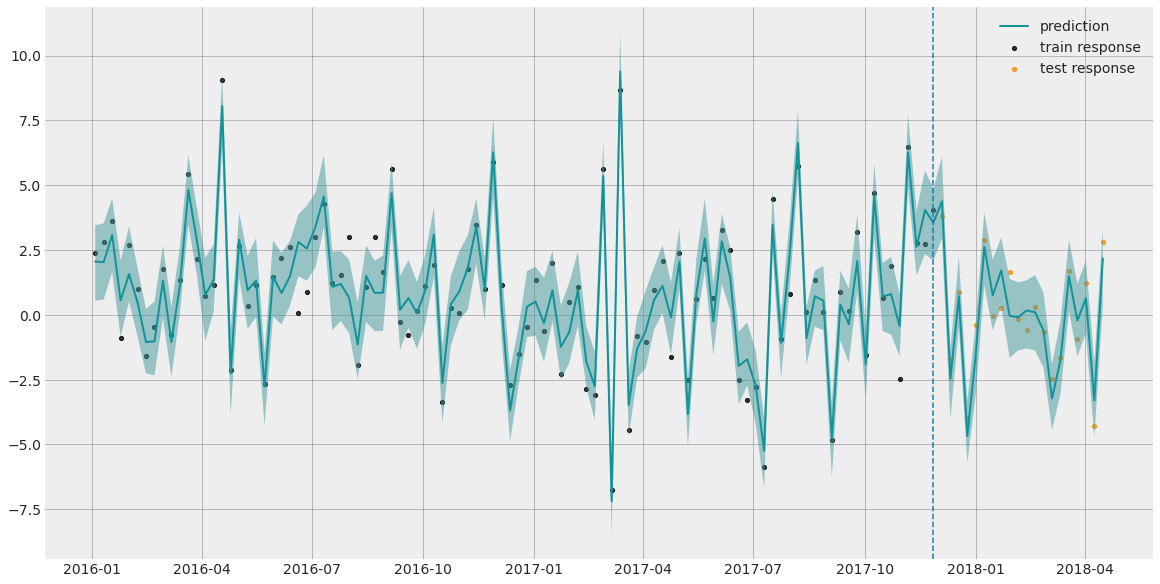

In [15]:
_ = plot_predicted_data(train_df, predicted_df, 'week', 'y', test_actual_df=test_df, prediction_percentiles=[5, 95])